We start by interpolating the thermophysical properties of the solid:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
T = np.array([20, 100, 200, 300, 400]) + 273.15
k_s = np.array([147, 155, 159, 159, 155])
c = np.array([739, 755, 797, 838, 922])

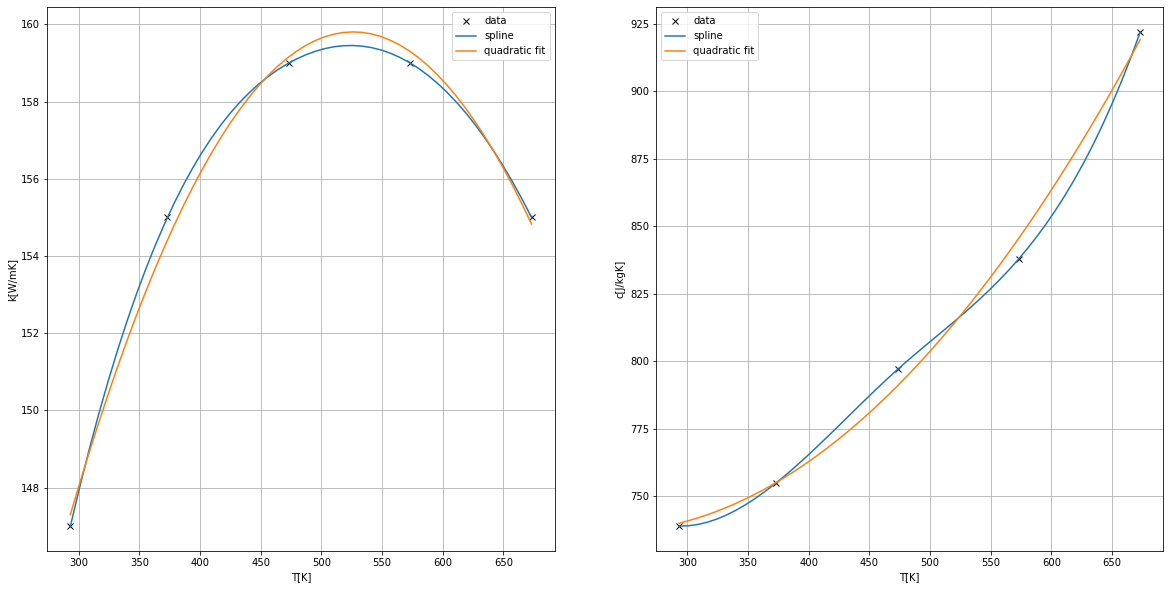

In [3]:
from scipy.optimize import curve_fit

T_range = np.linspace(20, 400) + 273.15

def func(x, a, b, c):
    return a + b*x + c*x**2

k_interpolate = scipy.interpolate.CubicSpline(T, k_s)
c_interpolate = scipy.interpolate.CubicSpline(T, c)

p_k, q_k = curve_fit(func, T, k_s)
p_c, q_c = curve_fit(func, T, c)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 10))

ax1.plot(T, k_s, 'kx', label = 'data')
ax1.plot(T_range, k_interpolate(T_range), label = 'spline')
ax1.plot(T_range, func(T_range, p_k[0], p_k[1], p_k[2]), label = 'quadratic fit')
ax1.set_xlabel('T[K]')
ax1.set_ylabel('k[W/mK]')
ax1.grid()
ax1.legend()

ax2.plot(T, c, 'kx', label = 'data')
ax2.plot(T_range, c_interpolate(T_range), label = 'spline')
ax2.plot(T_range, func(T_range, p_c[0], p_c[1], p_c[2]), label = 'quadratic fit')
ax2.set_xlabel('T[K]')
ax2.set_ylabel('c[J/kgK]')
ax2.grid()
ax2.legend()

Defining the geometry of the powderbed:

In [4]:
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(12345)

x = 1.54e-3
y = 0.7e-3
z = 0.1e-3

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0), (x, y, z))

Set the default float type to float64


Defining the time and the domian:

In [5]:
t = 0.005

time = dde.geometry.TimeDomain(0.0, t)
domain = dde.geometry.GeometryXTime(geo, time)

Defining the other properties:

In [6]:
rho = 2650.0
A = 0.09
D = 70e-6
R = D/2
P = 250
v = 200e-3
T_0 = 273.15

Defining the top boundary neglecting the convection and radiation:

In [7]:
def top_bc(X):
    
    r_sq = (X[:,0] - x/4 - X[:,3]*v)**2 + (X[:,1] - y/2)**2
    
    return 2*A*P/(np.pi*R**2)*np.exp(-2*r_sq/R**2)

Plotting the end position of teh laser beam on the surface

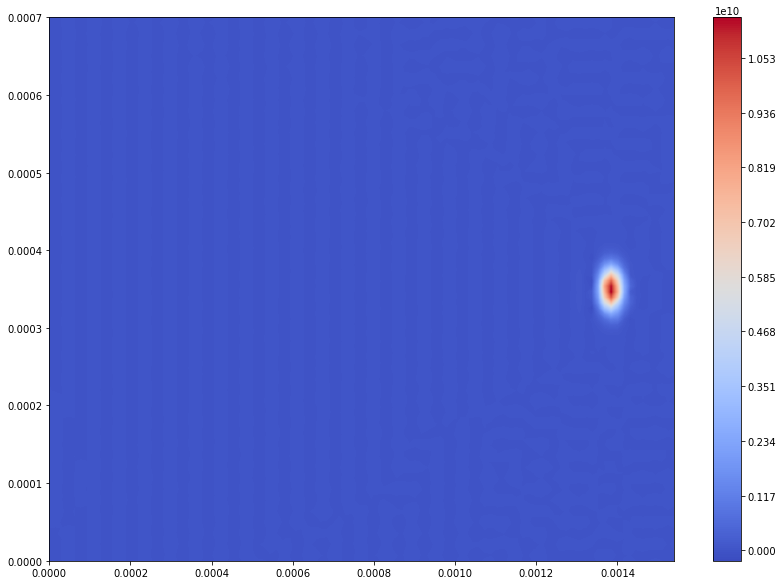

In [8]:
from scipy.interpolate import griddata

x_lin = np.linspace(0, x)
y_lin = np.linspace(0, y)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z], [0.005])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), top_bc(X), (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 1000, cmap=plt.cm.coolwarm)
plt.colorbar()

defining the pde system:

In [9]:
def pde_system(X, output):#
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    dT_dt = dde.grad.jacobian(T, X, j = 3)
    
    k_eff = func(T, p_k[0], p_k[1], p_k[2])
    c_eff = func(T, p_c[0], p_c[1], p_c[2])
    
    #k_eff = 155
    #c_eff = 922
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1) + dde.grad.jacobian(k_eff*dT_dz, X, j = 2)
    
    f_T = rho*c_eff*dT_dt - diff_T
    
    return f_T

def dummy(X, output):
    return output

Defining initial and boundary conditions:

In [10]:
def top_bc_new(X):
    
    r_sq = (X[:,0:1] - x/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y/2)**2
    
    return 2*A*P/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)

ic = dde.icbc.IC(domain, lambda on_initial: 20 + T_0, lambda _, on_initial: on_initial)
#top = dde.icbc.NeumannBC(domain, top_bc(x), lambda on_boundary, x: on_boundary and np.isclose(x[2], z))
top = dde.icbc.RobinBC(domain, lambda X, y : top_bc_new(X)/func(y, p_k[0], p_k[1], p_k[2]), lambda x, on_boundary: on_boundary and np.isclose(x[2], z, atol=z/10))
sides = dde.icbc.DirichletBC(domain, lambda X : 20 + T_0, lambda x, on_boundary: on_boundary and not np.isclose(x[2], z, atol=z/10))

creating the dataset:

In [11]:
time = dde.geometry.TimeDomain(0.0, t)
domain = dde.geometry.GeometryXTime(geo, time)

#setting training points at teh importtant part of the boundary
x_lin = np.linspace(0.1*x, 0.9*x, 10)
y_lin = np.linspace(1/3*y, 2/3*y, 10)
z_lin = np.linspace(0.9*z, z, 10)
t_lin = np.linspace(0, t, 10)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_lin], [t_lin])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

data = dde.data.TimePDE(domain,
                        pde_system,
                       ic_bcs=[ic, top, sides],
                       num_domain=100,
                       num_initial=100,
                       num_boundary = 100,
                       train_distribution="pseudo",
                       anchors=X)

In [12]:
#net = dde.nn.FNN([4] + [20] * 8 + [1], "sin", "Glorot normal")
net = dde.nn.MsFFN([4] + [60] * 4 + [1], "sin", "Glorot normal", sigmas = [1e-1, 1])

def feature_transform(X):
    return tf.concat(
        [X[:, 0:1]/x, 
         X[:, 1:2]/y,
         X[:, 2:3]/z,
        X[:, 3:4]/t], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4]
    Temperature = Y
    T_new = Temperature*1000 + 20 + T_0
    return T_new
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)
losshistory, train_state = model.train(epochs=0, display_every=1000)

Compiling model...
Building Multiscale Fourier Feature Network...


/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
2022-05-21 17:23:25.317746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 17:23:25.339173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 17:23:25.339467: I tensorflow/stream_execu

'compile' took 3.640342 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.71e+25, 3.60e+05, 3.41e+14, 6.19e+05]    [6.71e+25, 3.60e+05, 3.41e+14, 6.19e+05]    []  

Best model at step 0:
  train loss: 6.71e+25
  test loss: 6.71e+25
  test metric: []

'train' took 1.120215 s



In [13]:
weights = 1/np.array(losshistory.loss_train[0])
weights_2 = np.array([1, 1, 1, 1])
model.compile("adam", lr=1e-3, loss_weights=weights*weights_2)
resampler = dde.callbacks.PDEResidualResampler(100)
losshistory, train_state = model.train(epochs=2000, display_every=1000, callbacks=[resampler])

Compiling model...
'compile' took 2.047691 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.62e-01, 4.15e-01, 1.38e-01, 3.53e-01]    [3.62e-01, 4.15e-01, 1.38e-01, 3.53e-01]    []  
1000      [4.49e-04, 1.13e-04, 4.11e-02, 4.73e-04]    [4.49e-04, 1.13e-04, 4.11e-02, 4.73e-04]    []  
2000      [2.96e-04, 4.91e-05, 4.00e-02, 2.88e-04]    [4.24e-04, 4.91e-05, 4.00e-02, 2.88e-04]    []  

Best model at step 2000:
  train loss: 4.06e-02
  test loss: 4.08e-02
  test metric: []

'train' took 512.292681 s



In [27]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=2000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 2.095291 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
4061      [2.61e-03, 5.88e-05, 1.09e-02, 8.23e-05]    [1.46e-01, 5.88e-05, 1.09e-02, 8.23e-05]    []  
4100      [2.52e-03, 5.54e-05, 1.09e-02, 7.71e-05]                                                    
4200      [2.19e-03, 4.36e-05, 1.05e-02, 7.72e-05]                                                    
4300      [2.21e-03, 4.66e-05, 9.86e-03, 9.31e-05]                                                    
4400      [2.13e-03, 5.53e-05, 9.26e-03, 9.76e-05]                                                    
4500      [2.21e-03, 5.98e-05, 8.46e-03, 1.13e-04]                                                    
4600      [2.16e-03, 6.63e-05, 7.76e-03, 1.18e-04]                                                    
4700      [2.14e-03, 6.65e-05, 7.01e-03, 8.34e-05]                                                    
4

In [28]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=10000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights)
losshistory, train_state = model.train(epochs = 1000, display_every=100, callbacks=[resampler])

Compiling model...
'compile' took 3.078592 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
6200      [1.41e-03, 5.15e-05, 2.47e-03, 2.27e-05]    [3.08e-01, 5.15e-05, 2.47e-03, 2.27e-05]    []  
6300      [1.30e-03, 3.87e-05, 2.44e-03, 1.75e-05]                                                    
6400      [1.22e-03, 3.18e-05, 2.38e-03, 1.37e-05]                                                    
6500      [1.17e-03, 2.76e-05, 2.31e-03, 1.27e-05]                                                    
6600      [1.12e-03, 2.73e-05, 2.21e-03, 1.27e-05]                                                    
6700      [1.11e-03, 2.94e-05, 2.09e-03, 9.11e-06]                                                    
6800      [1.09e-03, 3.14e-05, 1.98e-03, 1.11e-05]                                                    
6900      [1.07e-03, 3.32e-05, 1.88e-03, 1.15e-05]                                                    
7

14000     [2.12e-04, 1.55e-05, 1.72e-04, 2.03e-06]                                                    
14100     [2.10e-04, 1.52e-05, 1.66e-04, 1.69e-06]                                                    
14200     [2.06e-04, 1.49e-05, 1.62e-04, 1.39e-06]                                                    
14300     [2.03e-04, 1.47e-05, 1.58e-04, 1.15e-06]                                                    
14400     [2.00e-04, 1.44e-05, 1.54e-04, 1.12e-06]                                                    
14500     [1.97e-04, 1.42e-05, 1.51e-04, 1.10e-06]                                                    
14600     [1.97e-04, 1.42e-05, 1.50e-04, 1.08e-06]                                                    
14700     [1.97e-04, 1.42e-05, 1.50e-04, 1.09e-06]                                                    
14800     [1.97e-04, 1.42e-05, 1.50e-04, 1.09e-06]                                                    
14900     [1.97e-04, 1.42e-05, 1.50e-04, 1.09e-06]                       

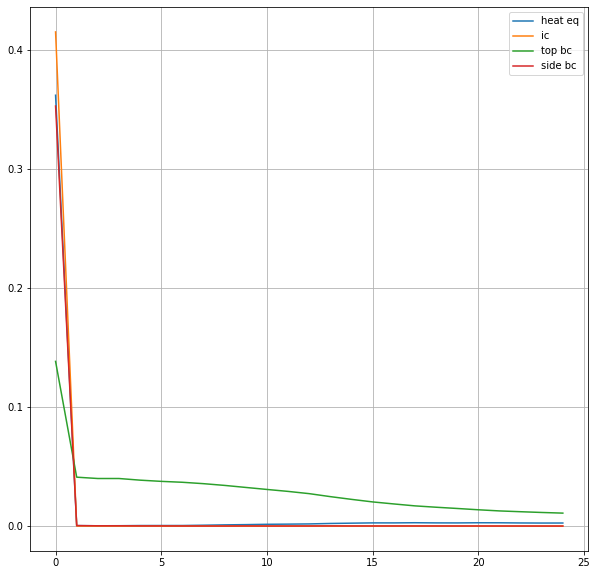

In [23]:
loss_names = ['heat eq', 'ic','top bc', 'side bc']
n = 1
plt.figure(figsize = (10, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

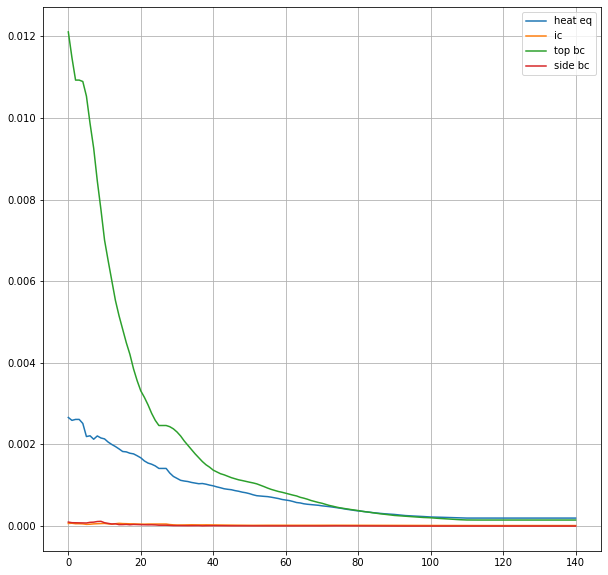

In [29]:
loss_names = ['heat eq', 'ic','top bc', 'side bc']
n = 23
plt.figure(figsize = (10, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

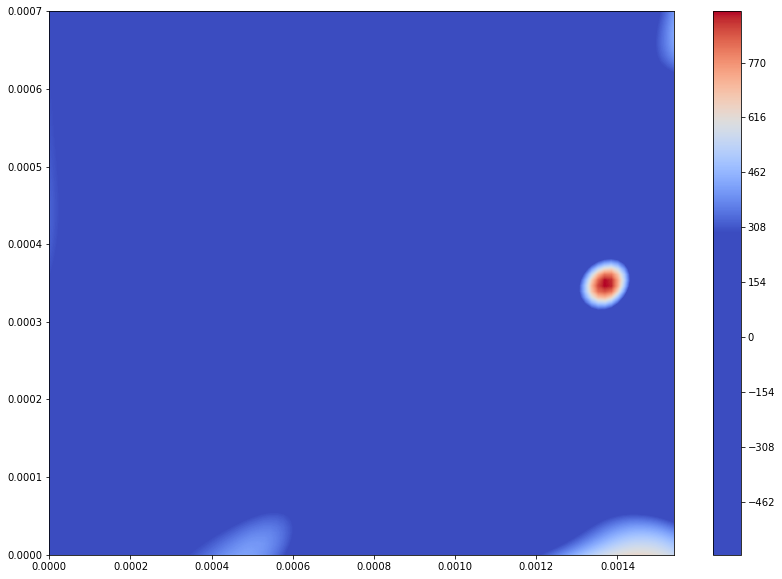

In [30]:
x_lin = np.linspace(0, x)
y_lin = np.linspace(0, y)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z], [t])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 1000, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

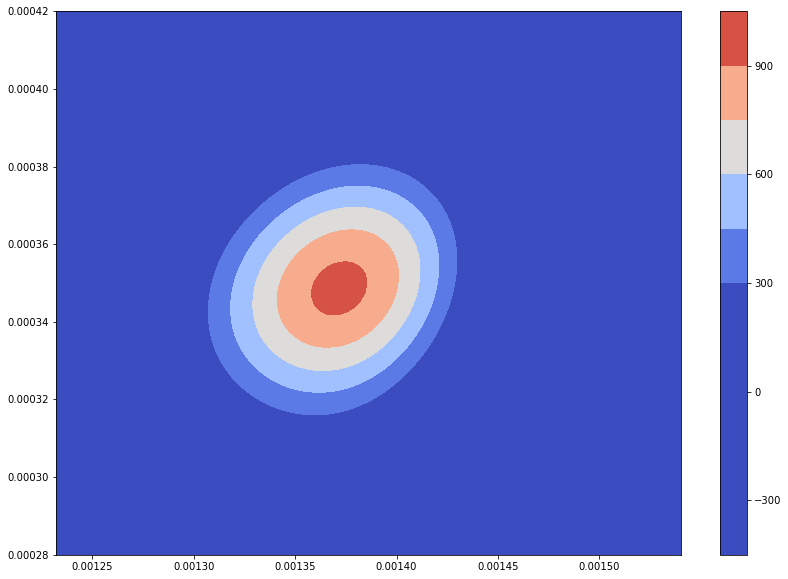

In [31]:
x_lin = np.linspace(0.8*x, x)
y_lin = np.linspace(0.4*y, 0.6*y)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z], [t])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 10, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

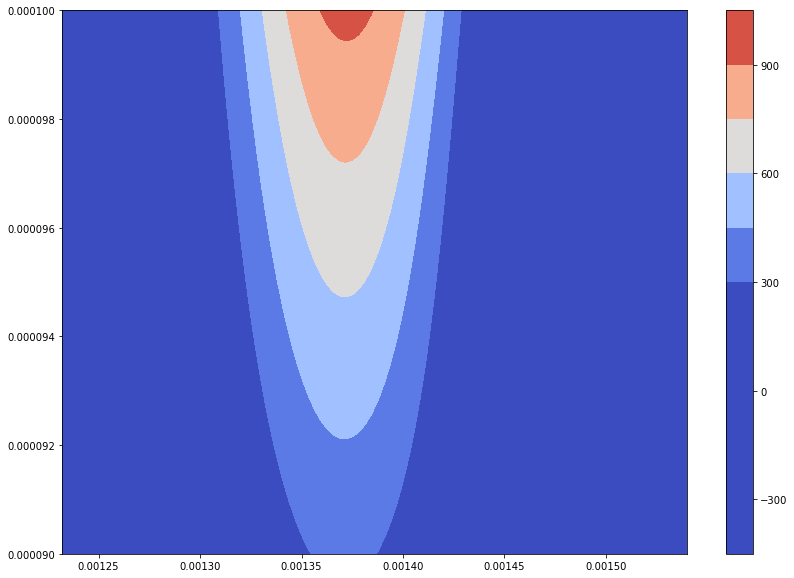

In [32]:
x_lin = np.linspace(0.8*x, x)
z_lin = np.linspace(0.9*z, z)
xx, yy, zz, tt = np.meshgrid(x_lin, [y/2], z_lin, [t])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
zi = np.linspace(zz.min(), zz.max(), 100)
data = griddata((np.ravel(xx), np.ravel(zz)), Y[:,0], (xi[None,:], zi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, zi, data, 10, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

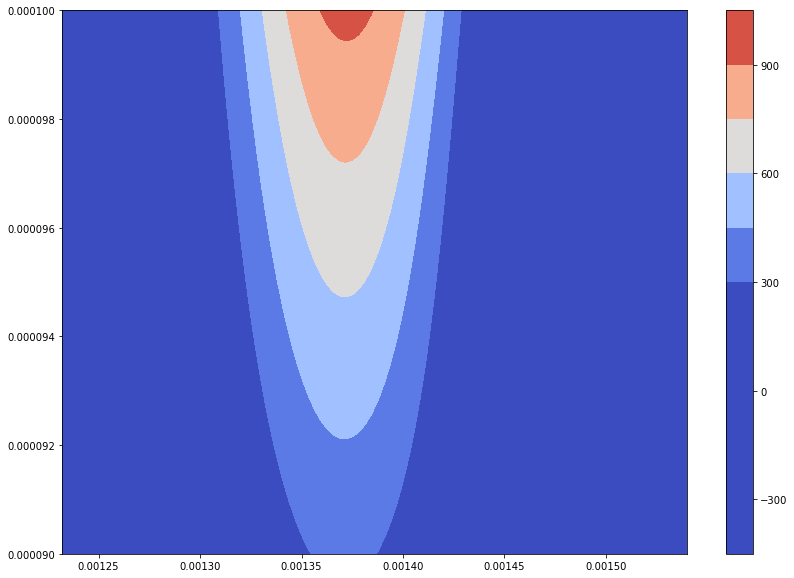

In [33]:
x_lin = np.linspace(0.8*x, x)
z_lin = np.linspace(0.9*z, z)
xx, yy, zz, tt = np.meshgrid(x_lin, [y/2], z_lin, [t])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
zi = np.linspace(zz.min(), zz.max(), 100)
data = griddata((np.ravel(xx), np.ravel(zz)), Y[:,0], (xi[None,:], zi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, zi, data, 10, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

In [21]:
data.min()

269.7720290157086

In [34]:
model.save('precicion/')

INFO:tensorflow:precicion/-17409.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'precicion/-17409.ckpt'